# The Battle of Neighborhoods - Sydney 
**Exploring for a Cafe Business Opportunity**

Applied Data Science Capstone Project  
Sreenivas Ramakrishnan

## Table of contents

1. [Introduction: Business Problem and Statement](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Results and Discussion](#results)
5. [Conclusion](#conclusion)

## Introduction: Business Problem and Statement <a name="introduction"></a>

New South Wales (abbreviated as NSW) is a state on the east coast of Australia. It borders Queensland to the north, Victoria to the south, and South Australia to the west. As of June 2020, the New South Wales has a population of over 8.1 million, making it Australia's most populous state.  The greater Sydney metropolitan area, which extends over 12,368 square km, has a staggering population of 5.3 million and is the most populous city in Australia and Oceania. Despite being one of the most expensive cities in the world, Sydney frequently ranks in the top ten most liveable cities in the world [1]. Built attractions such as the Sydney Harbour Bridge and the World Heritage-listed Sydney Opera House are also well known to international visitors.

Business opportunities abound in Sydney, but the food-and-beverage (F&B) sector has long been an attractive target for investors. The NSW food industry is a significant contributor to the economy with 55,000 food businesses across the state. The food processing industry alone contributes $25 billion [2].

Australia’s cafe and coffee shops generated about $9.9 billion of revenue last financial year, according to an IBISWorld Industry Report, across almost 21,000 businesses – one-third of which are in NSW. Cafe and restaurant culture is key to a great lifestyle, according to the recently released Domain Liveable Sydney study. It was one of 19 factors used to assess the liveability of 569 suburbs across Greater Sydney. [3]

With the aforementioned prospect, various stakeholders (entrepreneurs, investors) may be interested to explore cafe business opportunities in Sydney. This data science project is thus carried out to help them answer the following question: **Which of the Sydney suburbs are strategic for opening a cafe business?**

The project may also be of interest to fellow restaurant enthusiasts.

## Data <a name="data"></a>

In order to explore potential answer to the problems, the following data are required:

1. **The names of administrative regions in Sydney and their corresponding postal codes**. The regions include only the division of suburbs in Sydney. The information was scraped from a directory on https://www.intosydneydirectory.com.au/sydney-postcodes.php. The suburb names are useful to perform analysis across different areas. The postal codes are needed to obtain coordinates of each suburbs.
2. **Geographical coordinates** of Sydney's suburbs, which will in turn be needed to utilize Foursquare API in the subsequent step. Coordinates are obtained using GeoPy libraries, with [Arcgis](https://developers.arcgis.com/documentation/) and [Nominatim](https://nominatim.org/release-docs/latest/api/Overview/) API.
3. **Information about venues in Sydney suburbs**: the names, venue category, venue latitudes, venue longitudes. These are obtained using [Foursquare](https://developer.foursquare.com/) API. The suburbs of Sydney will be clustered based on their surrounding venues to find the best location candidates for opening a cafe.

Before we begin our analysis, the following libraries will be imported.

In [622]:
# Libraries for data analysis
import pandas as pd
import numpy as np

# Libraries for web scraping
import requests
import lxml
from time import sleep  
from bs4 import BeautifulSoup 

# Libraries for geocoding#
import geocoder
from geopy.geocoders import Nominatim 
import json

# Libraries for data visualization
import folium  
import matplotlib.pyplot as plt
import matplotlib.cm as cm  
import matplotlib.colors as colors

# Libraries for machine learning
from sklearn.cluster import KMeans 
from sklearn.metrics import silhouette_score  # 
print('Libraries imported.')

Libraries imported.


Two dataframes will be created for use in the analysis:
1. **df_sydney**: contains postal codes and geographical coordinates of all Sydney's suburbs.
2. **sydvenues**: contains at most 50 venues and venues details (name, category, latitude, longitude) for every suburb in Sydney.

### Web Scraping: Sydney Suburbs and Postal Codes

The data to scrape are the names of all Sydney suburbs and their corresponding postal codes. I first need to specify the URL of the webpage to which I will send **get** request. 

In [ ]:
# Define headers so that the url you are requesting does not consider you as a bot
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.90 Safari/537.36"}

# Page url for Sydney's suburbs and using beautiful soup to scarpe the webpage for postal codes and suburbs
res = requests.get('https://www.intosydneydirectory.com.au/sydney-postcodes.php', headers=headers)

In [ ]:
soup = BeautifulSoup(res.text, 'lxml')
tables = soup.find('td', id="mainText")
fields = tables.find_all('table')
print(fields)

In [48]:
# A for loop for looping thorugh all the td values 
for row in fields:
    col = row.find_all('td')

print(col)

# Empty lists to store extracted data
postalcodes = []
state = []
suburbs = []

# Loop through <td> tags to extract data
for td in range(0, len(col), 3):
    postalcodes.append(col[td+2].text.strip())
    state.append(col[td+1].text.strip())
    suburbs.append(col[td].text.strip())

# Structure the data into a dataframe 
df = pd.DataFrame({
    'PostalCode':postalcodes,
    'State':state,
    'Suburbs':suburbs,
})

print(f'Dataframe shape: {df.shape[0]} rows, {df.shape[1]} columns.')
df.head()

[<td>Abbotsbury</td>, <td>NSW</td>, <td>2176</td>, <td>Abbotsford</td>, <td>NSW</td>, <td>2046</td>, <td>Agnes Banks</td>, <td>NSW</td>, <td>2753</td>, <td>Airds</td>, <td>NSW</td>, <td>2560</td>, <td>Alexandria</td>, <td>NSW</td>, <td>2015</td>, <td>Alfords Point</td>, <td>NSW</td>, <td>2234</td>, <td>Allambie Heights</td>, <td>NSW</td>, <td>2100</td>, <td>Allawah</td>, <td>NSW</td>, <td>2218</td>, <td>Ambarvale</td>, <td>NSW</td>, <td>2560</td>, <td>Annandale</td>, <td>NSW</td>, <td>2038</td>, <td>Annangrove</td>, <td>NSW</td>, <td>2156</td>, <td>Appin</td>, <td>NSW</td>, <td>2560</td>, <td>Arcadia</td>, <td>NSW</td>, <td>2159</td>, <td>Arncliffe</td>, <td>NSW</td>, <td>2205</td>, <td>Arndell Park</td>, <td>NSW</td>, <td>2148</td>, <td>Artarmon</td>, <td>NSW</td>, <td>2064</td>, <td>Ashbury</td>, <td>NSW</td>, <td>2193</td>, <td>Ashcroft</td>, <td>NSW</td>, <td>2168</td>, <td>Ashfield</td>, <td>NSW</td>, <td>2131</td>, <td>Asquith</td>, <td>NSW</td>, <td>2077</td>, <td>Auburn</td>, <

,PostalCode,State,Suburbs
0,2176,NSW,Abbotsbury
1,2046,NSW,Abbotsford
2,2753,NSW,Agnes Banks
3,2560,NSW,Airds
4,2015,NSW,Alexandria


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PostalCode  689 non-null    object
 1   State       689 non-null    object
 2   Suburbs     689 non-null    object
dtypes: object(3)
memory usage: 16.3+ KB


### Retrieval of geographical co-ordinates

**Use geopy library to get the latitude and longitude values of Sydney**

Using the postal codes as inputs, the arcgis geocoder will be used to retrieve latitudes and longitudes of every suburbs.

In [51]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Sydney, Australia'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords

In [52]:
latitude = [] # empty list for latitude
longitude = [] # empty list for longitude

# add the values latidude and lonitude by calling the function to the empty list
for i in range(0,len(df)):
    postcode = df['PostalCode'].values[i]
    a = get_latilong(postcode)
    latitude.append(a[0])
    longitude.append(a[1])

#convert to series of data
df['Latitude'] = latitude
df['Longitude'] = longitude    

In [53]:
sydney_1 = df.reset_index(drop = True)
sydney_1.head()

,PostalCode,State,Suburbs,Latitude,Longitude
0,2176,NSW,Abbotsbury,-33.868755,150.883195
1,2046,NSW,Abbotsford,-33.859164,151.130670
2,2753,NSW,Agnes Banks,-33.651864,150.753264
3,2560,NSW,Airds,-34.056554,150.824705
4,2015,NSW,Alexandria,-33.911604,151.191855


Check the information about the dataframe: indices, columns, missing values, data types.

In [54]:
sydney_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689 entries, 0 to 688
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PostalCode  689 non-null    object 
 1   State       689 non-null    object 
 2   Suburbs     689 non-null    object 
 3   Latitude    689 non-null    float64
 4   Longitude   689 non-null    float64
dtypes: float64(2), object(3)
memory usage: 27.0+ KB


In [55]:
regions = sydney_1.groupby('State').agg({'Suburbs':'nunique',}).reset_index()

print(f'Number of Suburbs    : {regions.Suburbs.sum()}')
regions

Number of Suburbs    : 689


,State,Suburbs
0,NSW,689


In [62]:
# to save computation, we can save the new data frame into a csv file
# Save the dataframe as a CSV file
sydney_1.to_csv('Sydney_coordinates.csv', index=False)

We can see from the final data frame, there are some similar suburbs e.g. Bankstown - North-East, Bankstown - West, etc. A further investigation when plotting the coordinates on a map of Sydney shows that picking out the first MultiPoint was not very accurate. As I cannot find any data sets online which have correct single coordinates, I cleaned up the data frame manually. I removed all other duplicates of the same suburbs (e.g. east, west) as they overlapped other suburbs.

In [63]:
# removing duplicate suburbs or overlapping ones
df_sydney = sydney_1.drop([10, 24, 28, 30, 41, 47, 59, 60, 63, 65, 73, 75, 80, 81, 84, 88, 102, 107, 109, 110, 118, 
                         122, 129, 130, 137, 139, 141, 162, 166, 176, 182, 188, 196, 197, 208, 212, 213, 214, 215, 
                         216, 217, 230, 241, 242, 243, 247, 258, 259, 260, 261, 263, 279, 281, 283, 301, 302, 305, 
                         311, 314, 324, 331, 332, 333, 334, 340, 349, 350, 352, 368, 380, 381, 382, 387, 405, 407, 
                         409, 412, 415, 418, 424, 429, 430, 431, 432, 433, 434, 435, 442, 452, 455, 456, 457, 458, 
                         459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 474, 475, 478, 487, 494, 
                         499, 510, 513, 522, 525, 532, 536, 537, 541, 542, 543, 544, 546, 557, 571, 572, 573, 574, 
                         575, 576, 577, 578, 584, 588, 589, 594, 601, 602, 603, 604, 606, 616, 620, 625, 626, 650, 
                         652, 653, 654, 655, 664, 665, 668, 674, 680])
# see resulting data frame
df_sydney = df_sydney.reset_index(drop=True)s
df_sydney

,PostalCode,State,Suburbs,Latitude,Longitude
0,2176,NSW,Abbotsbury,-33.868755,150.883195
1,2046,NSW,Abbotsford,-33.859164,151.130670
2,2753,NSW,Agnes Banks,-33.651864,150.753264
3,2560,NSW,Airds,-34.056554,150.824705
4,2015,NSW,Alexandria,-33.911604,151.191855
...,...,...,...,...,...
528,2233,NSW,Yarrawarrah,-34.104722,150.989380
529,2777,NSW,Yellow Rock,-33.677959,150.609697
530,2161,NSW,Yennora,-33.856955,150.980942
531,2228,NSW,Yowie Bay,-34.038752,151.105045


## Methodology <a name="methodology"></a>

This section contains the main components of the report. Starting with the web scraping of Sydney suburbs and postal codes followed by retrieval of geographical coordinates. Using **Foursquare API**, the suburb's location coordinates are given as inputs to explore venues within the Sydney's suburbs.

One-hot encoding is performed to analyze and narrow down the most common venues in each of the suburbs. Given all the venues surrounding them, suburbs are clustered using **K-means algorithm**. The number of optimal clusters is decided using the elbow method and silhouette score. Each cluster is separately analyzed to examine one discriminating venue that characterizes them. Analysis of the clusters and visualization of cafe distribution across Sydney will give significant insights on the strategic suburbs for setting up a cafe business.

**Use geopy library to get the latitude and longitude values of Sydney**

In [65]:
# Get geographical coordinates of Sydney
address = 'Sydney'

geolocator = Nominatim(user_agent="sydney_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Sydney are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Sydney are -33.8548157, 151.2164539.


In [67]:
# create map of Sydney using latitude and longitude values
map_TO = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, suburbs in zip(df_sydney['Latitude'], df_sydney['Longitude'], df_sydney['Suburbs']):
    label = '{}'.format(suburbs)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_TO)  
    
map_TO

In [69]:
# to save computation, we can save the new data frame into a csv file
df_sydney.to_csv('sydney_data.csv', index=False)

In [444]:
df_sydney1 = pd.read_csv('sydney_data.csv')
df_sydney1.head()

,PostalCode,State,Suburbs,Latitude,Longitude
0,2176,NSW,Abbotsbury,-33.868755,150.883195
1,2046,NSW,Abbotsford,-33.859164,151.130670
2,2753,NSW,Agnes Banks,-33.651864,150.753264
3,2560,NSW,Airds,-34.056554,150.824705
4,2015,NSW,Alexandria,-33.911604,151.191855


In [445]:
df_sydney1.shape

(533, 5)

**Define Foursquare Credentials**

In [446]:
CLIENT_ID = 'R2X33R3FLFB0KMY3NRD55Q4D55OQ53GSIWR3TG1XUT2ASAAA' # your Foursquare ID
CLIENT_SECRET = 'H2KONSS25GEQ2KTYUQT0TXJI15IY5YJPGM2FG4XXVDFCYIXI' # your Foursquare Secret
VERSION = '20210326' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: R2X33R3FLFB0KMY3NRD55Q4D55OQ53GSIWR3TG1XUT2ASAAA
CLIENT_SECRET:H2KONSS25GEQ2KTYUQT0TXJI15IY5YJPGM2FG4XXVDFCYIXI


**Let's create a function to repeat the process to all the suburbs in Sydney region**

In [447]:
import requests
def getNearbyVenues(subs, latitudes, longitudes, radius=1000, limit=50):
    
    venues_list=[]
    for subs1, lat, lng in zip(subs, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            subs1,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Suburbs', 
                  'Latitude',
                  'Longitude',  
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [448]:
# Run the function, save as the dataframe 'sydvenues'
sydvenues = getNearbyVenues(df_sydney1['Suburbs'],
    df_sydney1['Latitude'],
    df_sydney1['Longitude'])

print(f'{sydvenues.shape[0]} venues collected.')
sydvenues.head(10)

15206 venues collected.


,Suburbs,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.868755,150.883195,SUPA IGA St Johns Park,-33.871541,150.890444,Grocery Store
1,Abbotsbury,-33.868755,150.883195,Star Buffet (Club Marconi),-33.864698,150.879435,Buffet
2,Abbotsbury,-33.868755,150.883195,Fratelli's Italian Restaurant,-33.867551,150.882156,Italian Restaurant
3,Abbotsbury,-33.868755,150.883195,Powhatan Park,-33.867138,150.885525,Park
4,Abbotsbury,-33.868755,150.883195,Marconi Club,-33.864336,150.880726,Bar
5,Abbotsbury,-33.868755,150.883195,Bodyworks Life Gym,-33.864520,150.879300,Gym
6,Abbotsbury,-33.868755,150.883195,Maison Coffee,-33.871530,150.890440,Café
7,Abbotsbury,-33.868755,150.883195,Club Marconi,-33.864539,150.880778,Pizza Place
8,Abbotsbury,-33.868755,150.883195,Coles,-33.876032,150.876902,Supermarket
9,Abbotsford,-33.859164,151.130670,Musa Taekwondo,-33.865258,151.130161,Martial Arts School


In [463]:
# to save computation, we can save the new data frame into a csv file
sydvenues.to_csv('sydney_venues.csv', index=False)

In [484]:
df_sydney2 = pd.read_csv('sydney_venues.csv')
df_sydney2.head()

,Suburbs,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbotsbury,-33.868755,150.883195,SUPA IGA St Johns Park,-33.871541,150.890444,Grocery Store
1,Abbotsbury,-33.868755,150.883195,Star Buffet (Club Marconi),-33.864698,150.879435,Buffet
2,Abbotsbury,-33.868755,150.883195,Fratelli's Italian Restaurant,-33.867551,150.882156,Italian Restaurant
3,Abbotsbury,-33.868755,150.883195,Powhatan Park,-33.867138,150.885525,Park
4,Abbotsbury,-33.868755,150.883195,Marconi Club,-33.864336,150.880726,Bar


Check the information about the dataframe: indices, columns, missing values, data types.

In [485]:
df_sydney2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15206 entries, 0 to 15205
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Suburbs          15206 non-null  object 
 1   Latitude         15206 non-null  float64
 2   Longitude        15206 non-null  float64
 3   Venue            15206 non-null  object 
 4   Venue Latitude   15206 non-null  float64
 5   Venue Longitude  15206 non-null  float64
 6   Venue Category   15206 non-null  object 
dtypes: float64(4), object(3)
memory usage: 831.7+ KB


Looking good. Now checking the number of venues that were returned for each subdistrict.

In [486]:
venuescount_suburbs = df_sydney2.groupby('Suburbs')['Venue'].count().reset_index(name='Venue Count')
venuescount_suburbs.head(10)

,Suburbs,Venue Count
0,Abbotsbury,9
1,Abbotsford,27
2,Airds,20
3,Alexandria,73
4,Alfords Point,23
5,Allambie Heights,8
6,Allawah,19
7,Ambarvale,20
8,Annandale,88
9,Appin,20


In [487]:
venuescount_suburbs.describe().T

,count,mean,std,min,25%,50%,75%,max
Venue Count,519.0,29.298651,31.449927,1.0,6.0,15.0,37.0,100.0


Out of 533 suburbs only 519 were returned by Foursquare API. The remaining suburbs will be having NaN values. These will be subsequently removed during clustering of the suburbs. 

## Top 10 Venues overall

In [488]:
top10_sydvenues = df_sydney2.groupby('Venue Category').size().reset_index(name='Count')
top10_sydvenues.sort_values('Count', ascending=False).reset_index(drop=True).head(10)

,Venue Category,Count
0,Café,2004
1,Coffee Shop,628
2,Park,534
3,Fast Food Restaurant,428
4,Thai Restaurant,405
5,Bar,383
6,Pizza Place,378
7,Shopping Mall,324
8,Supermarket,313
9,Japanese Restaurant,300


Various kinds of restaurant top the list of most common venues in Sydney. Cafe, which is our venue of interest, comes in first. With almost 2000 cafes in Sydney, it sure is a very competitive business.

## One hot encoding

One-hot encoding will help convert categorical variables (i.e., venues) into numeric variables. In this case, we will take the mean of the frequency of venue occurrence within a suburb.

In [489]:
# Move all venue category into dummy indicators
ohe_suburbs = pd.get_dummies(df_sydney2['Venue Category'], prefix="", prefix_sep="")

# Group by suburbs, calculate the mean
ohe_suburbs['Suburbs'] = df_sydney2['Suburbs'] 
ohe_suburbs = ohe_suburbs.groupby('Suburbs').mean().reset_index()
print(f'Dataframe shape: {ohe_suburbs.shape[0]} rows, {ohe_suburbs.shape[1]} columns.')
ohe_suburbs.head(10)

Dataframe shape: 519 rows, 355 columns.


,Suburbs,ATM,Accessories Store,Advertising Agency,Afghan Restaurant,Airfield,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,...,Vietnamese Restaurant,Warehouse Store,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Abbotsbury,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Abbotsford,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.037037,0.0,0.0,0.0
2,Airds,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Alexandria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013699,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,Alfords Point,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
5,Allambie Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
6,Allawah,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
7,Ambarvale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
8,Annandale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011364,0.0,0.0,0.0,0.0,0.0,0.022727,0.0,0.0,0.0
9,Appin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


#### Most common venues in each suburb

The following cell contains a function that will help us sort venues in each suburb. In this analysis, we will take only 5 most common venues each.

In [490]:
# A function to sort venues in a descending order of frequency
def top_venues(row, num_venues):
    row_cats = row.iloc[1:]
    row_cats_sorted = row_cats.sort_values(ascending=False)
    return row_cats_sorted.index.values[0:num_venues]

In [491]:
num_venues = 5 # number of top venues
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
cols = ['Suburbs']
for i in np.arange(num_venues):
    try:
        cols.append(f"{i+1}{indicators[i]} Most Common Venue")
    except:
        cols.append(f"{i+1}th Most Common Venue")

# Create a dataframe of 5 most common venues by district
common_venues = pd.DataFrame(columns=cols)
common_venues['Suburbs'] = ohe_suburbs['Suburbs']

for i in np.arange(ohe_suburbs.shape[0]):
    common_venues.iloc[i, 1:] = top_venues(ohe_suburbs.iloc[i, :], num_venues)

common_venues.head(10)

,Suburbs,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Abbotsbury,Italian Restaurant,Grocery Store,Park,Bar,Café
1,Abbotsford,Café,Grocery Store,Park,Coffee Shop,Burger Joint
2,Airds,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
3,Alexandria,Café,Playground,Furniture / Home Store,Electronics Store,Italian Restaurant
4,Alfords Point,Fast Food Restaurant,Supermarket,Indoor Play Area,Bus Station,Thai Restaurant
5,Allambie Heights,Scenic Lookout,American Restaurant,Fast Food Restaurant,Liquor Store,Gym
6,Allawah,Pub,Train Station,Park,Paper / Office Supplies Store,Shoe Store
7,Ambarvale,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
8,Annandale,Café,Park,Grocery Store,Pub,Pizza Place
9,Appin,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place


In [492]:
common_venues.shape

(519, 6)

## Clustering suburbs based on the similarity of venues

### K-means clustering

The suburbs will be clustered or segmented based on a set of similar characteristics or features, i.e., their surrounding venues. K-Means clustering, which is used in this part of the analysis, is a machine learning algorithm that creates homogeneous subgroups/clusters from unlabeled data such that data points in each cluster are as similar as possible to each other according to a similarity measure (e.g., Euclidian distance).

Selecting the features (F): all venue category columns from the one-hot encoding dataframe.

In [493]:
F = ohe_suburbs.drop('Suburbs', 1) # Select features

Before proceeding, we need to determine a value of *k* (number of clusters). The **Elbow Method** below calculates the sum of squared distances of data points to their closest centroid (cluster center) for different values of *k*. The optimal value of *k* is the one after which there is a plateau (no significant decrease in sum of squared distances).

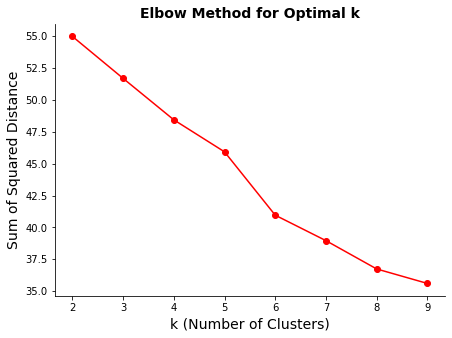

In [532]:
k_range = range(2,10)  # Range of k values to test
ssd = []  # Sum of Squared Distance

for k in k_range:
    model = KMeans(n_clusters=k, random_state=0).fit(F)
    ssd.append(model.inertia_)

plt.figure(figsize=(7,5))
plt.plot(k_range, ssd, 'ro-')
plt.title('Elbow Method for Optimal k', size=14, weight='bold')
plt.xlabel('k (Number of Clusters)', size=14)
plt.ylabel('Sum of Squared Distance', size=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('elbow.png', dpi=300, bbox_inches='tight')
plt.show()

Because there is no conspicuous "elbow" from the plot, another measure will be used: **Silhouette Score**.

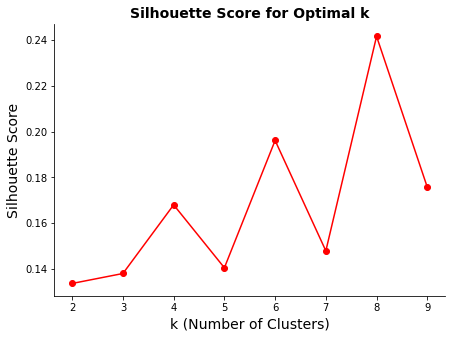

In [531]:
k_silh = range(2,10)
silh = []

for k in k_silh:
    model = KMeans(n_clusters=k, random_state=0).fit(F)
    labels = model.labels_
    silh.append(silhouette_score(F, labels, metric='euclidean'))

plt.figure(figsize=(7,5))
plt.plot(k_silh, silh, 'ro-')
plt.title('Silhouette Score for Optimal k', size=14, weight='bold')
plt.xlabel('k (Number of Clusters)', size=14)
plt.ylabel('Silhouette Score', size=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.savefig('silhouette.png', dpi=300, bbox_inches='tight')
plt.show()

Silhouette score varies from -1 to 1. A score value of 1 means the cluster is dense and well-separated from other clusters. A value nearing 0 represents overlapping clusters, data points are close to the decision boundary of neighboring clusters. A negative score indicates that the samples might have been assigned into the wrong clusters. From the plot above, there is a peak at **k = 8**. We will proceed with that value as the number of optimal clusters.

In [497]:
k = 8 # number of clusters

# Run K-Means algorithm, random_state=0 to generate reproducible results
model = KMeans(n_clusters=k, random_state=0).fit(F)
model.labels_ # Cluster labels generated for each row

array([2, 2, 5, 2, 7, 7, 7, 5, 2, 5, 4, 7, 7, 2, 2, 7, 2, 7, 7, 7, 7, 2,
       2, 2, 2, 2, 2, 7, 2, 2, 7, 2, 2, 7, 5, 7, 2, 5, 7, 2, 7, 5, 2, 7,
       6, 7, 2, 2, 7, 2, 3, 2, 4, 2, 7, 6, 5, 2, 2, 7, 5, 7, 5, 2, 2, 1,
       2, 2, 7, 2, 2, 7, 3, 5, 2, 2, 5, 2, 2, 2, 7, 6, 2, 2, 2, 7, 2, 2,
       2, 6, 7, 2, 5, 2, 2, 2, 2, 2, 2, 7, 7, 7, 2, 7, 2, 5, 5, 7, 1, 6,
       5, 2, 2, 2, 2, 2, 7, 0, 2, 5, 2, 7, 2, 1, 2, 2, 2, 2, 7, 6, 5, 2,
       1, 7, 2, 2, 7, 2, 5, 2, 1, 7, 2, 2, 2, 7, 5, 2, 2, 2, 2, 5, 2, 2,
       2, 2, 7, 2, 5, 5, 5, 7, 5, 2, 2, 2, 2, 2, 2, 7, 2, 7, 7, 1, 2, 7,
       1, 2, 2, 7, 3, 6, 2, 6, 2, 5, 2, 2, 5, 2, 7, 2, 2, 1, 2, 7, 2, 4,
       2, 7, 1, 2, 2, 4, 7, 5, 5, 2, 2, 6, 5, 1, 2, 7, 6, 7, 7, 7, 7, 2,
       2, 7, 5, 7, 2, 2, 5, 5, 2, 5, 1, 2, 5, 7, 2, 0, 7, 7, 7, 5, 7, 7,
       5, 2, 7, 2, 2, 7, 7, 5, 3, 2, 2, 2, 7, 1, 5, 2, 2, 3, 5, 7, 7, 2,
       6, 7, 2, 2, 2, 2, 2, 0, 7, 2, 2, 2, 7, 2, 1, 2, 2, 7, 5, 5, 2, 2,
       2, 2, 2, 2, 0, 5, 7, 6, 2, 2, 1, 7, 7, 7, 5,

In [498]:
# Add cluster labels into existing dataframe
common_venues.insert(1, 'Cluster', model.labels_)

# Join dataframes to add other information
# i.e., latitude, longitude, suburb
clustered = df_sydney1.join(common_venues.set_index('Suburbs'), on='Suburbs').reset_index(drop=True)
clustered.head(10)

,PostalCode,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2176,NSW,Abbotsbury,-33.868755,150.883195,2.0,Italian Restaurant,Grocery Store,Park,Bar,Café
1,2046,NSW,Abbotsford,-33.859164,151.130670,2.0,Café,Grocery Store,Park,Coffee Shop,Burger Joint
2,2753,NSW,Agnes Banks,-33.651864,150.753264,NaN,NaN,NaN,NaN,NaN,NaN
3,2560,NSW,Airds,-34.056554,150.824705,5.0,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
4,2015,NSW,Alexandria,-33.911604,151.191855,2.0,Café,Playground,Furniture / Home Store,Electronics Store,Italian Restaurant
5,2234,NSW,Alfords Point,-34.018790,151.009984,7.0,Fast Food Restaurant,Supermarket,Indoor Play Area,Bus Station,Thai Restaurant
6,2100,NSW,Allambie Heights,-33.759207,151.254850,7.0,Scenic Lookout,American Restaurant,Fast Food Restaurant,Liquor Store,Gym
7,2218,NSW,Allawah,-33.970735,151.119975,7.0,Pub,Train Station,Park,Paper / Office Supplies Store,Shoe Store
8,2560,NSW,Ambarvale,-34.056554,150.824705,5.0,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
9,2038,NSW,Annandale,-33.880686,151.169685,2.0,Café,Park,Grocery Store,Pub,Pizza Place


In [494]:
# Libraries for data visualization
import folium  # Maps visualization
import matplotlib.pyplot as plt  # Data visualization
import matplotlib.cm as cm  # Color maps
import matplotlib.colors as colors

# Libraries for machine learning
from sklearn.cluster import KMeans  # Clustering algorithm
from sklearn.metrics import silhouette_score  # 

In [499]:
clustered.shape

(533, 11)

From the above table some of the venues were not returned by Foursquare API which gives rise to NaN values. So, we drop them

In [500]:
clustered = clustered.dropna()
clustered = clustered.reset_index(drop = True)
clustered

,PostalCode,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2176,NSW,Abbotsbury,-33.868755,150.883195,2.0,Italian Restaurant,Grocery Store,Park,Bar,Café
1,2046,NSW,Abbotsford,-33.859164,151.130670,2.0,Café,Grocery Store,Park,Coffee Shop,Burger Joint
2,2560,NSW,Airds,-34.056554,150.824705,5.0,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
3,2015,NSW,Alexandria,-33.911604,151.191855,2.0,Café,Playground,Furniture / Home Store,Electronics Store,Italian Restaurant
4,2234,NSW,Alfords Point,-34.018790,151.009984,7.0,Fast Food Restaurant,Supermarket,Indoor Play Area,Bus Station,Thai Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
514,2574,NSW,Yanderra,-33.869600,151.206910,2.0,Coffee Shop,Café,Shopping Mall,Speakeasy,Cocktail Bar
515,2777,NSW,Yellow Rock,-33.677959,150.609697,1.0,Pub,Café,Shopping Mall,Soccer Field,Grocery Store
516,2161,NSW,Yennora,-33.856955,150.980942,7.0,Shopping Mall,Sports Club,Soccer Field,Recycling Facility,Library
517,2228,NSW,Yowie Bay,-34.038752,151.105045,2.0,Café,Department Store,Coffee Shop,Fast Food Restaurant,Supermarket


In [501]:
# change cluster values to integer
clustered['Cluster'] = clustered['Cluster'].astype(int)
clustered

,PostalCode,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,2176,NSW,Abbotsbury,-33.868755,150.883195,2,Italian Restaurant,Grocery Store,Park,Bar,Café
1,2046,NSW,Abbotsford,-33.859164,151.130670,2,Café,Grocery Store,Park,Coffee Shop,Burger Joint
2,2560,NSW,Airds,-34.056554,150.824705,5,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
3,2015,NSW,Alexandria,-33.911604,151.191855,2,Café,Playground,Furniture / Home Store,Electronics Store,Italian Restaurant
4,2234,NSW,Alfords Point,-34.018790,151.009984,7,Fast Food Restaurant,Supermarket,Indoor Play Area,Bus Station,Thai Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
514,2574,NSW,Yanderra,-33.869600,151.206910,2,Coffee Shop,Café,Shopping Mall,Speakeasy,Cocktail Bar
515,2777,NSW,Yellow Rock,-33.677959,150.609697,1,Pub,Café,Shopping Mall,Soccer Field,Grocery Store
516,2161,NSW,Yennora,-33.856955,150.980942,7,Shopping Mall,Sports Club,Soccer Field,Recycling Facility,Library
517,2228,NSW,Yowie Bay,-34.038752,151.105045,2,Café,Department Store,Coffee Shop,Fast Food Restaurant,Supermarket


#### Visualizing Clusters

Now that each suburb has been assigned a cluster label, it would be helpful to visualize the clusters on a map of Sydney to see how they are distributed across the regions. Folium library is used for this purpose.

In [546]:
# Define latitude of Sydney, Australia
syd_lat, syd_lng = -33.8548157, 151.2164539

# Create a map of Sydney
map_clusters = folium.Map(
    location=[syd_lat, syd_lng],
    zoom_start=11,
)

# Set color scheme for the different clusters
x = np.arange(k)  # k = number of clusters
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers and popups to the map
for lat, lng, subs, clust in zip(
    clustered['Latitude'],
    clustered['Longitude'],
    clustered['Suburbs'],
    clustered['Cluster']):
    
    label = folium.Popup(f'Cluster {clust}: {subs}')
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[clust-1],
        fill=True,
        fill_color=rainbow[clust-1],
        fill_opacity=0.7,
    ).add_to(map_clusters)

map_clusters # Display the map


In [503]:
map_clusters.save('folium-map-clusters.html')  # Save the map

**Let's find some labels for our clusters by creating a barplot of the most common venues to see how we can label them.**

In [504]:
top_venue_count = clustered
top_venue_count = top_venue_count.drop(['PostalCode','State','Suburbs','Latitude','Longitude'], axis=1)
top_venue_count = top_venue_count.groupby(['Cluster', '1st Most Common Venue']).size().reset_index(name='Count')
top_venue_count

,Cluster,1st Most Common Venue,Count
0,0,Park,8
1,1,BBQ Joint,3
2,1,Miscellaneous Shop,19
3,1,Pub,6
4,2,Bakery,3
...,...,...,...
61,7,Shopping Mall,2
62,7,Sports Bar,3
63,7,Supermarket,2
64,7,Thai Restaurant,3


Let's transpose the data frame so that the columns are 1st Most Common Venue

In [505]:
cluster_venue = top_venue_count.pivot(index='Cluster', columns='1st Most Common Venue', values='Count')
# change NaN values to 0
cluster_venue = cluster_venue.fillna(0).astype(int).reset_index(drop=True)
cluster_venue

1st Most Common Venue,BBQ Joint,Bakery,Bus Station,Café,Campground,Chinese Restaurant,Clothing Store,Coffee Shop,Convenience Store,Dam,...,Pizza Place,Platform,Pub,Scenic Lookout,Shopping Mall,Sports Bar,Supermarket,Thai Restaurant,Train Station,Vietnamese Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,6,0,0,0,0,0,0,0
2,0,3,0,167,2,3,0,25,2,0,...,3,0,3,0,0,0,2,6,0,2
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,...,4,0,3,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,19,0,0,0
7,0,1,8,0,0,2,1,0,12,0,...,8,8,2,5,2,3,2,3,13,0


(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7')])

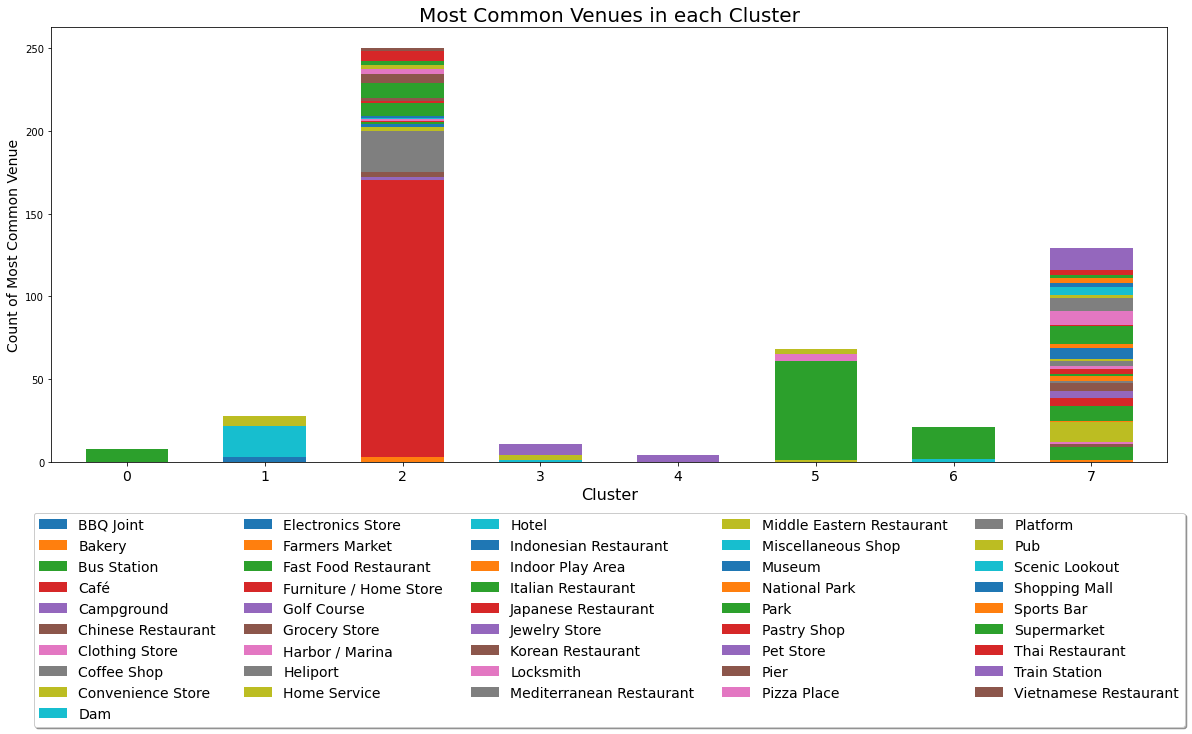

In [561]:
# Create a bar chart of most common venues of each cluster
cv_plot = cluster_venue.plot(kind='bar', stacked=True,
                            figsize=(20,8),
                            width=0.6)
plt.title("Most Common Venues in each Cluster", fontsize=20)
plt.xlabel("Cluster", fontsize=16)
plt.ylabel("Count of Most Common Venue", fontsize=14)
plt.legend(labels=cluster_venue.columns, fontsize=14, loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.xticks(rotation=0, fontsize=14)

### Examination of Each Cluster

Each cluster is filtered from the dataframe previously created in the clustering stage. The clusters are separately analyzed in order to gain an understanding of a distinct venue that characterize each of them. In other words, the 1st most common venue category from each cluster will be singled out. 

#### Cluster 0 (red)

In [512]:
# A list of column index number for reordering purpose
clust_check_cols = [1,2,3,4,5,6,7] + list(range(8, clustered.shape[1]))

# Filter only Cluster 0 
cluster0 = clustered.loc[clustered['Cluster'] == 0, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster0.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Chifley,-33.970445,151.23645,0,Park,Shipping Store,Gym,Bus Stop,Restaurant
1,NSW,Hillsdale,-33.970445,151.23645,0,Park,Shipping Store,Gym,Bus Stop,Restaurant
2,NSW,La Perouse,-33.970445,151.23645,0,Park,Shipping Store,Gym,Bus Stop,Restaurant
3,NSW,Little Bay,-33.970445,151.23645,0,Park,Shipping Store,Gym,Bus Stop,Restaurant
4,NSW,Malabar,-33.970445,151.23645,0,Park,Shipping Store,Gym,Bus Stop,Restaurant


In [513]:
cluster0.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,8,8,8,8,8
unique,1,2,2,2,2
top,Park,Shipping Store,Gym,Bus Stop,Restaurant
freq,8,7,7,7,7


In [514]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster0 = cluster0.iloc[:, 5].value_counts().reset_index()
top1_cluster0.columns = ['1st Most Common Venue', 'Count']
top1_cluster0

,1st Most Common Venue,Count
0,Park,8


#### Cluster 1 (Purple)

In [515]:
# Filter only Cluster 1
cluster1 = clustered.loc[clustered['Cluster'] == 1, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster1.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Bligh Park,-33.61488,150.840475,1,Miscellaneous Shop,Garden Center,Café,Shopping Mall,Grocery Store
1,NSW,Cattai,-33.61488,150.840475,1,Miscellaneous Shop,Garden Center,Café,Shopping Mall,Grocery Store
2,NSW,Clarendon,-33.61488,150.840475,1,Miscellaneous Shop,Garden Center,Café,Shopping Mall,Grocery Store
3,NSW,Colo,-33.61488,150.840475,1,Miscellaneous Shop,Garden Center,Café,Shopping Mall,Grocery Store
4,NSW,Cornwallis,-33.61488,150.840475,1,Miscellaneous Shop,Garden Center,Café,Shopping Mall,Grocery Store


In [516]:
cluster1.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,28,28,28,28,28
unique,3,3,3,3,2
top,Miscellaneous Shop,Garden Center,Café,Shopping Mall,Grocery Store
freq,19,19,19,19,25


In [517]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster1 = cluster1.iloc[:, 5].value_counts().reset_index()
top1_cluster1.columns = ['1st Most Common Venue', 'Count']
top1_cluster1

,1st Most Common Venue,Count
0,Miscellaneous Shop,19
1,Pub,6
2,BBQ Joint,3


#### Cluster 2 (Dark blue)

In [518]:
# Filter only Cluster 2
cluster2 = clustered.loc[clustered['Cluster'] == 2, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster2.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Abbotsbury,-33.868755,150.883195,2,Italian Restaurant,Grocery Store,Park,Bar,Café
1,NSW,Abbotsford,-33.859164,151.130670,2,Café,Grocery Store,Park,Coffee Shop,Burger Joint
2,NSW,Alexandria,-33.911604,151.191855,2,Café,Playground,Furniture / Home Store,Electronics Store,Italian Restaurant
3,NSW,Annandale,-33.880686,151.169685,2,Café,Park,Grocery Store,Pub,Pizza Place
4,NSW,Artarmon,-33.811965,151.184781,2,Café,Japanese Restaurant,Convenience Store,Electronics Store,Thai Restaurant


In [519]:
cluster2.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,250,250,250,250,250
unique,22,41,43,52,57
top,Café,Café,Park,Speakeasy,Cocktail Bar
freq,167,35,34,29,24


In [520]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster2 = cluster2.iloc[:, 5].value_counts().reset_index()
top1_cluster2.columns = ['1st Most Common Venue', 'Count']
top1_cluster2

,1st Most Common Venue,Count
0,Café,167
1,Coffee Shop,25
2,Park,9
3,Italian Restaurant,8
4,Thai Restaurant,6
5,Pier,5
6,Pizza Place,3
7,Bakery,3
8,Chinese Restaurant,3
9,Pub,3


#### Cluster 3 (light blue)

In [521]:
# Filter only Cluster 3
cluster3 = clustered.loc[clustered['Cluster'] == 3, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster3.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Berkshire Park,-33.662261,150.887208,3,Pet Store,Home Service,ATM,Other Great Outdoors,Pakistani Restaurant
1,NSW,Box Hill,-33.662261,150.887208,3,Pet Store,Home Service,ATM,Other Great Outdoors,Pakistani Restaurant
2,NSW,Elanora Heights,-33.689410,151.258112,3,Home Service,Hill,Golf Course,ATM,Other Great Outdoors
3,NSW,Ingleside,-33.689410,151.258112,3,Home Service,Hill,Golf Course,ATM,Other Great Outdoors
4,NSW,Kenthurst,-33.652497,150.973855,3,Dam,Home Service,ATM,Organic Grocery,Pakistani Restaurant


In [522]:
cluster3.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,11,11,11,11,11
unique,3,2,2,3,2
top,Pet Store,Home Service,ATM,Other Great Outdoors,Pakistani Restaurant
freq,7,8,8,7,8


In [523]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster3 = cluster3.iloc[:, 5].value_counts().reset_index()
top1_cluster3.columns = ['1st Most Common Venue', 'Count']
top1_cluster3

,1st Most Common Venue,Count
0,Pet Store,7
1,Home Service,3
2,Dam,1


#### Cluster 4 (cyan)

In [524]:
# Filter only Cluster 4
cluster4 = clustered.loc[clustered['Cluster'] == 4, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster4.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Arcadia,-33.588862,151.089055,4,Jewelry Store,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store
1,NSW,Berrilee,-33.588862,151.089055,4,Jewelry Store,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store
2,NSW,Fiddletown,-33.588862,151.089055,4,Jewelry Store,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store
3,NSW,Galston,-33.588862,151.089055,4,Jewelry Store,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store


In [525]:
cluster4.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,4,4,4,4,4
unique,1,1,1,1,1
top,Jewelry Store,ATM,Organic Grocery,Pakistani Restaurant,Outlet Store
freq,4,4,4,4,4


In [526]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster4 = cluster4.iloc[:, 5].value_counts().reset_index()
top1_cluster4.columns = ['1st Most Common Venue', 'Count']
top1_cluster4

,1st Most Common Venue,Count
0,Jewelry Store,4


#### Cluster 5 (Green)

In [527]:
# Filter only Cluster 5
cluster5 = clustered.loc[clustered['Cluster'] == 5, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster5.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Airds,-34.056554,150.824705,5,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
1,NSW,Ambarvale,-34.056554,150.824705,5,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
2,NSW,Appin,-34.056554,150.824705,5,Fast Food Restaurant,Indoor Play Area,Pizza Place,Paper / Office Supplies Store,Sandwich Place
3,NSW,Bardia,-33.981286,150.864460,5,Fast Food Restaurant,Café,Outdoor Supply Store,Gym,Golf Course
4,NSW,Bass Hill,-33.900605,150.998596,5,Fast Food Restaurant,Shopping Mall,Gym,Park,Pizza Place


In [528]:
cluster5.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,68,68,68,68,68
unique,4,11,10,12,14
top,Fast Food Restaurant,Supermarket,Pizza Place,Paper / Office Supplies Store,Sandwich Place
freq,60,16,15,15,15


In [529]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster5 = cluster5.iloc[:, 5].value_counts().reset_index()
top1_cluster5.columns = ['1st Most Common Venue', 'Count']
top1_cluster5

,1st Most Common Venue,Count
0,Fast Food Restaurant,60
1,Pizza Place,4
2,Pub,3
3,Convenience Store,1


#### Cluster 6 (light green)

In [533]:
# Filter only Cluster 6
cluster6 = clustered.loc[clustered['Cluster'] == 6, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster6.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Belimbla Park,-34.061671,150.694666,6,Supermarket,Café,Bar,Australian Restaurant,ATM
1,NSW,Bickley Vale,-34.061671,150.694666,6,Supermarket,Café,Bar,Australian Restaurant,ATM
2,NSW,Brownlow Hill,-34.061671,150.694666,6,Supermarket,Café,Bar,Australian Restaurant,ATM
3,NSW,Camden,-34.061671,150.694666,6,Supermarket,Café,Bar,Australian Restaurant,ATM
4,NSW,Cawdor,-34.061671,150.694666,6,Supermarket,Café,Bar,Australian Restaurant,ATM


In [534]:
cluster6.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,21,21,21,21,21
unique,2,2,2,2,2
top,Supermarket,Café,Bar,Australian Restaurant,ATM
freq,19,19,19,19,19


In [535]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster6 = cluster6.iloc[:, 5].value_counts().reset_index()
top1_cluster6.columns = ['1st Most Common Venue', 'Count']
top1_cluster6

,1st Most Common Venue,Count
0,Supermarket,19
1,Scenic Lookout,2


#### Cluster 7 (orange)

In [536]:
# Filter only Cluster 7
cluster7 = clustered.loc[clustered['Cluster'] == 7, clustered.columns[clust_check_cols]].reset_index(drop=True)
cluster7.head()

,State,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,NSW,Alfords Point,-34.018790,151.009984,7,Fast Food Restaurant,Supermarket,Indoor Play Area,Bus Station,Thai Restaurant
1,NSW,Allambie Heights,-33.759207,151.254850,7,Scenic Lookout,American Restaurant,Fast Food Restaurant,Liquor Store,Gym
2,NSW,Allawah,-33.970735,151.119975,7,Pub,Train Station,Park,Paper / Office Supplies Store,Shoe Store
3,NSW,Arncliffe,-33.936582,151.149184,7,Park,Hotel,Grocery Store,Chinese Restaurant,Outlet Store
4,NSW,Arndell Park,-33.781381,150.900600,7,Convenience Store,Liquor Store,Thai Restaurant,Auto Garage,Shopping Mall


In [537]:
cluster7.iloc[:,5:].describe()  # Statistical summary

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
count,129,129,129,129,129
unique,30,36,38,40,35
top,Train Station,Park,Convenience Store,Shopping Mall,Park
freq,13,10,11,10,12


In [538]:
# Filter the no. 1 most common venues in the cluster 
top1_cluster7 = cluster7.iloc[:, 5].value_counts().reset_index()
top1_cluster7.columns = ['1st Most Common Venue', 'Count']
top1_cluster7

,1st Most Common Venue,Count
0,Train Station,13
1,Convenience Store,12
2,Park,11
3,Fast Food Restaurant,9
4,Pizza Place,8
5,Platform,8
6,Bus Station,8
7,Museum,7
8,Grocery Store,5
9,Furniture / Home Store,5


The Clusters 1,2,6 have the cafe venues in the top 5. So, the cafes venues are filtered in order to visualise the concentration of cafes across Sydney regions.  

In [608]:
# Filter only Café
# Cluster 2 has the cafe venues as 1st and 2nd most common venue, filtering out only the cafe venues for cluster 2
top_cafe_suburbs_c2 = cluster2[['Suburbs','Latitude','Longitude','Cluster','1st Most Common Venue','2nd Most Common Venue']]
top_cafe_suburbs_c2_1 = top_cafe_suburbs_c2.loc[top_cafe_suburbs_c2['1st Most Common Venue'] == 'Café'].reset_index(drop=True).drop(columns=['2nd Most Common Venue'])
top_cafe_suburbs_c2_2 = top_cafe_suburbs_c2.loc[top_cafe_suburbs_c2['2nd Most Common Venue'] == 'Café'].reset_index(drop=True).drop(columns=['1st Most Common Venue'])
top_cafe_suburbs_c2_1.head()

,Suburbs,Latitude,Longitude,Cluster,1st Most Common Venue
0,Abbotsford,-33.859164,151.130670,2,Café
1,Alexandria,-33.911604,151.191855,2,Café
2,Annandale,-33.880686,151.169685,2,Café
3,Artarmon,-33.811965,151.184781,2,Café
4,Ashbury,-33.905730,151.123045,2,Café


In [609]:
top_cafe_suburbs_c2_1 = top_cafe_suburbs_c2_1.rename(columns={"1st Most Common Venue": "Cafe Venues"})
top_cafe_suburbs_c2_1.head()

,Suburbs,Latitude,Longitude,Cluster,Cafe Venues
0,Abbotsford,-33.859164,151.130670,2,Café
1,Alexandria,-33.911604,151.191855,2,Café
2,Annandale,-33.880686,151.169685,2,Café
3,Artarmon,-33.811965,151.184781,2,Café
4,Ashbury,-33.905730,151.123045,2,Café


In [610]:
top_cafe_suburbs_c2_2 = top_cafe_suburbs_c2_2.rename(columns={"2nd Most Common Venue": "Cafe Venues"})
top_cafe_suburbs_c2_2.head()

,Suburbs,Latitude,Longitude,Cluster,Cafe Venues
0,Avon,-33.8696,151.20691,2,Café
1,Badgerys Creek,-33.8696,151.20691,2,Café
2,Balmoral,-33.8696,151.20691,2,Café
3,Bar Point,-33.8696,151.20691,2,Café
4,Bargo,-33.8696,151.20691,2,Café


In [632]:
# Cluster 6 has the 2nd most common venue for cafe 
top_cafe_suburbs_c6 = cluster6[['Suburbs','Latitude','Longitude','Cluster','2nd Most Common Venue']]
top_cafe_suburbs_c6_1 = top_cafe_suburbs_c6.loc[top_cafe_suburbs_c6['2nd Most Common Venue'] == 'Café'].reset_index(drop=True)
top_cafe_suburbs_c6_1 = top_cafe_suburbs_c6_1.rename(columns={"2nd Most Common Venue": "Cafe Venues"})
top_cafe_suburbs_c6_1.head()

,Suburbs,Latitude,Longitude,Cluster,Cafe Venues
0,Belimbla Park,-34.061671,150.694666,6,Café
1,Bickley Vale,-34.061671,150.694666,6,Café
2,Brownlow Hill,-34.061671,150.694666,6,Café
3,Camden,-34.061671,150.694666,6,Café
4,Cawdor,-34.061671,150.694666,6,Café


In [633]:
# Cluster 1 has the 3rd most common venue for cafe
top_cafe_suburbs_c1 = cluster1[['Suburbs','Latitude','Longitude','Cluster','3rd Most Common Venue']]
top_cafe_suburbs_c1_1 = top_cafe_suburbs_c1.loc[top_cafe_suburbs_c1['3rd Most Common Venue'] == 'Café'].reset_index(drop=True)
top_cafe_suburbs_c1_1 = top_cafe_suburbs_c1_1.rename(columns={"3rd Most Common Venue": "Cafe Venues"})
top_cafe_suburbs_c1_1.head()

,Suburbs,Latitude,Longitude,Cluster,Cafe Venues
0,Bligh Park,-33.61488,150.840475,1,Café
1,Cattai,-33.61488,150.840475,1,Café
2,Clarendon,-33.61488,150.840475,1,Café
3,Colo,-33.61488,150.840475,1,Café
4,Cornwallis,-33.61488,150.840475,1,Café


In [620]:
# Merging all the cafe venues with different cluster values to create the final dataframe of all the top cafe venue suburbs
result = pd.concat([top_cafe_suburbs_c2_1, top_cafe_suburbs_c2_2, top_cafe_suburbs_c6_1, top_cafe_suburbs_c1_1], ignore_index=True, sort=False)
result.tail(10)

,Suburbs,Latitude,Longitude,Cluster,Cafe Venues
230,Lower Portland,-33.61488,150.840475,1,Café
231,Maroota,-33.61488,150.840475,1,Café
232,Mcgraths Hill,-33.61488,150.840475,1,Café
233,Mellong,-33.61488,150.840475,1,Café
234,Mulgrave,-33.61488,150.840475,1,Café
235,Pitt Town,-33.61488,150.840475,1,Café
236,Sackville,-33.61488,150.840475,1,Café
237,Scheyville,-33.61488,150.840475,1,Café
238,Wilberforce,-33.61488,150.840475,1,Café
239,Windsor,-33.61488,150.840475,1,Café


In [616]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Suburbs      240 non-null    object 
 1   Latitude     240 non-null    float64
 2   Longitude    240 non-null    float64
 3   Cluster      240 non-null    int32  
 4   Cafe Venues  240 non-null    object 
dtypes: float64(2), int32(1), object(2)
memory usage: 8.6+ KB


Distribution of cafes across Sydney suburbs using Folium Map with the clusters (1,2,6)

In [617]:
# Define latitude of Sydney, Australia
syd_lat, syd_lng = -33.8548157, 151.2164539

# Create a map of Sydney
map_clusters = folium.Map(
    location=[syd_lat, syd_lng],
    zoom_start=11,
)

# Set color scheme for the different clusters
x = np.arange(k)  # k = number of clusters
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers and popups to the map
for lat, lng, subs, clust in zip(
    result['Latitude'],
    result['Longitude'],
    result['Suburbs'],
    result['Cluster']):
    
    label = folium.Popup(f'Cluster {clust}: {subs}')
    
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[clust-1],
        fill=True,
        fill_color=rainbow[clust-1],
        fill_opacity=0.7,
    ).add_to(map_clusters)

map_clusters # Display the map


## Concentration of Cafes in Sydney Suburbs

In [455]:
oh_suburb = pd.get_dummies(df_sydney2['Venue Category'], prefix="", prefix_sep="")
oh_suburb['Suburbs'] = df_sydney2['Suburbs']
oh_suburb = oh_suburb.groupby('Suburbs').sum().reset_index()

# Filter only Café
cafe_suburbs = oh_suburb[['Suburbs','Café']].sort_values('Café', ascending=False).reset_index(drop=True)

In [456]:
cafe_suburbs.head(10)

,Suburbs,Café
0,Mcmahons Point,32
1,Waverton,32
2,Lavender Bay,32
3,Camperdown,24
4,Erskineville,21
5,Surry Hills,21
6,Redfern,20
7,Birchgrove,20
8,Balmain,20
9,Rushcutters Bay,20


In [457]:
cafe_suburbs.tail(10)

,Suburbs,Café
513,Gilead,0
514,Georges Hall,0
515,Phillip Bay,0
516,Picnic Point,0
517,Galston,0
518,Pitt Town,0
519,Pleasure Point,0
520,Plumpton,0
521,Freemans Reach,0
522,Kenthurst,0


In [458]:
cafe_suburbs1 = cafe_suburbs[cafe_suburbs.Café != 0]

In [459]:
cafe_suburbs1

,Suburbs,Café
0,Mcmahons Point,32
1,Waverton,32
2,Lavender Bay,32
3,Camperdown,24
4,Erskineville,21
...,...,...
340,Bass Hill,1
341,Bangor,1
342,Lovett Bay,1
343,Alfords Point,1


In [542]:
cafe_suburbs2 = cafe_suburbs1[['Suburbs','Café']].sort_values('Café', ascending=False).reset_index(drop=True)
cafe_suburbs2.head(10)

,Suburbs,Café
0,Mcmahons Point,32
1,Lavender Bay,32
2,Waverton,32
3,Camperdown,24
4,Erskineville,21
5,Surry Hills,21
6,Woolloomooloo,20
7,Mosman,20
8,Elizabeth Bay,20
9,Balmain,20


In [631]:
cafe_suburbs2.tail(10)

,Suburbs,Café
335,Smeaton Grange,1
336,Pendle Hill,1
337,Smithfield,1
338,Miller,1
339,Valley Heights,1
340,Padstow,1
341,St Johns Park,1
342,Sun Valley,1
343,Wakeley,1
344,Lalor Park,1


## Results and Discussion <a name="results"></a>

Exploratory data analysis as well as machine learning and visualization techniques have provided us with some insights into the problem at hand.

A total of 15206 venues from all Sydney regions (519 suburbs) were returned at the time the API call was made. There are on average 29 venues within a kilometer of a suburb center, where two of the most common categories overall are Cafes and Coffee Shops.

After deciding on an optimal *k* value of 8, *K*-Means algorithm was run to cluster the suburbs based on their most common surrounding venues. Each of the six clusters, labeled 0-7, is characterized by a dominant venue as follows:

Cluster|Member|#1 Common Venues 
-|-|-
0|8|Park
1|28|Miscellaneous Shop	
2|250|Cafe
3|11|Pet Store
4|4|Jewelry Store	
5|68|Fast Food Restaurant
6|21|Super Market
7|129|Train Station

A considerable number of cafes can be found within Cluster 2 (167 + 35 shops out of 250 venues). In fact, it is the 1st and 2nd most common venue in that cluster. It is recommended for people looking to visit or live in Sydney NSW to research more about the neighborhoods to investigate whether the areas suit their lifestyle or culture. The dark blue dots (Cluster 2) are mostly closer to the CBD area of Sydney, with the areas being characterized by café venues. The orange dots (Cluster 7) are further out from Sydney CBD, with the areas being characterized by their variety of venues. The green dots (Cluster 5) are even further away from Sydney CBD and has the most common venue for fast food restaurants.  

The clusters with most number of cafes within the Top 5 venues are listed as follows:

Cluster|Member|Type of Common Venue
-|-|-
1|19|3rd Most Common Venue
2|167|1st Most Common Venue	
2|35|2nd Most Common Venue
6|19|2nd Most Common Venue

A total of 202 cafes can be found within cluster 2 and it is the 1st and 2nd most common venue followed by cluster 6 (2nd most) and cluster 1 (3rd most). Folium map of cafe locations across mainland Sydney shows that Sydney CBD, Northern and Eastern Suburbs and Inner West has a very high concentration of the business, i.e., 202 cafes while the rest are way below 100. The suburbs in Sydney CBD and its surrounding regions, therefore, are not viable options for opening up a cafe business because they are already way too saturated. The highest number of cafes (32) are found to be in the Sydney CBD region with neighboring suburbs (Mcmahons Point, Waverton, Lavender Bay).  

It is recommended that stakeholders look into opportunities in the clusters (3,5,7) (e.g., Blackstown, Greater Western Sydney and South-Western Sydney) as these regions have the least concentration of cafes and would significantly minimize competition. If, however, a moderate competition is not a concern then suburbs in cluster (1,6) (e.g., Windsor and Camden) is recommended.

## Conclusion <a name="conclusion"></a>

Stakeholders searching for opportunities to open a cafe in Sydney may want to consider setting up their business someplace where competitions are not severe. Sydney regions were explored and then clustered based on the similarity of their surrounding venues using K-Means algorithm. Analysis results show that suburbs in the regions of Blackstown, Greater Western Sydney and South Western Sydney are among the best candidates for a new cafe location.

## References

1. Levy, Megan (2014). "Sydney, Melbourne more expensive than New York, says Living Index". The Sydney Morning Herald. Retrieved    20 July 2014.
2. https://www.foodauthority.nsw.gov.au/industry
3. Sydney’s top suburbs for density of cafes and restaurants, KATE BURKE, Nov 29, 2019. 